### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Explore-AI/Public-Data/master/house_price_by_area.csv")
df.head()

,LotArea,SalePrice
0,138,1204000
1,145,1274000
2,152,1673000
3,152,1232000
4,152,1195600


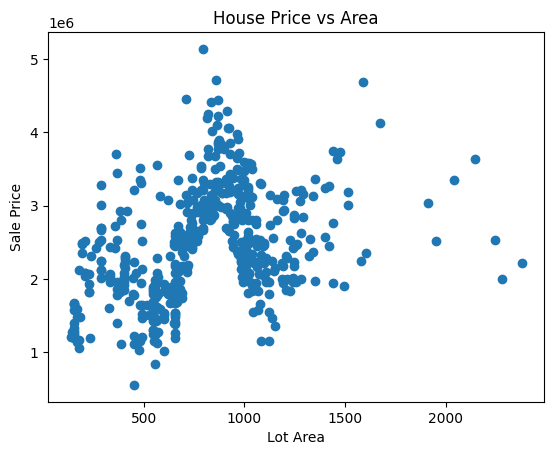

In [3]:
# Plotting the data

X = df["LotArea"] # independent variable
y = df["SalePrice"] # dependent variable

plt.scatter(X,y) # create scatter plot
plt.title("House Price vs Area")
plt.xlabel("Lot Area")
plt.ylabel("Sale Price")
plt.show()

### Preprocessing

In [4]:
# standardise features
scaler = StandardScaler()
# Convert to numpy array first to apply np.newaxis
X_scaled = scaler.fit_transform(np.array(X)[:,np.newaxis])

# Train test split
x_train, x_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=6)

### Training

This process of fitting a decision tree to our data can be done in `scikit-learn` with the ``RandomForestRegressor`` estimator:

As with decision trees, random forests also have hyperparameters. Some of the more important ones include:

- **n_estimators**: The number of trees to include in the forest.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node.
- **max_depth**: The maximum depth of each forest tree (i.e. the number of nodes between root and leaf node).
- **random_state**: A number used to seed the random number generator. Ensures that we get the same tree each time we call model.fit() – _this particular hyperparameter is important in random forests since their training procedure is inherently random._
- **criterion**: The function to measure the quality of a split. The model uses the mean squared error (MSE) by default.

> To learn more about other RandomForestRegressor hyperparameters, run `help(RandomForestRegressor)` in a new cell.

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Our forest consists of 100 trees with a max depth of 5 in this example
RF = RandomForestRegressor(n_estimators=100, max_depth=5)
RF.fit(x_train,y_train)

RandomForestRegressor(max_depth=5)

### Testing

To evaluate the performance of our model, we can report the **mean squared error** or **plot** predicted output vs. expected output.

In [6]:
# Get predictions
y_pred = RF.predict(x_test)

# Compute RMSE
print("RMSE:",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE: 595726.4610069399


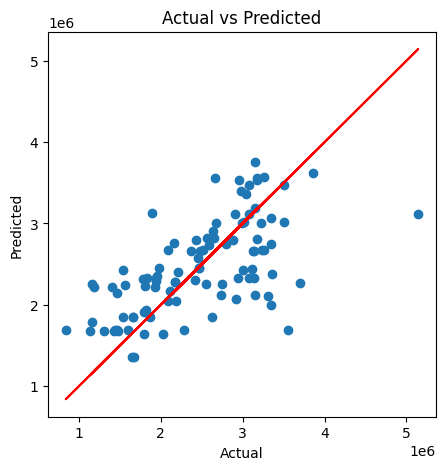

In [7]:
# Create figure and axes
f, ax = plt.subplots(figsize=(5,5))

# Plot actual vs. predicted values on axes
ax.set_title('Actual vs Predicted')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.scatter(y_test,y_pred)
ax.plot(y_test,y_test,'r')
plt.show()

### Tuning model hyperparameters

In most cases, the default hyperparameter values do not offer the best model performance. In such cases, we have to **tune model hyperparameters** to **yield the best-performing model**.

Let's make some changes to the `n_estimators` parameter and compare the results:

#### Training the various models:

In [8]:
# 2 trees in forest
forest_1 = RandomForestRegressor(n_estimators=2, max_depth=5, random_state=23)

# 20 trees in forest
forest_2 = RandomForestRegressor(n_estimators=20, max_depth=5, random_state=23)

# 100 trees in forest
forest_3 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=23)

In [9]:
forest_1.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=2, random_state=23)

In [10]:
forest_2.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=20, random_state=23)

In [11]:
forest_3.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, random_state=23)

#### Let's evaluate the models:

We calculate the RMSE for each model and plot the actual vs. predicted values:

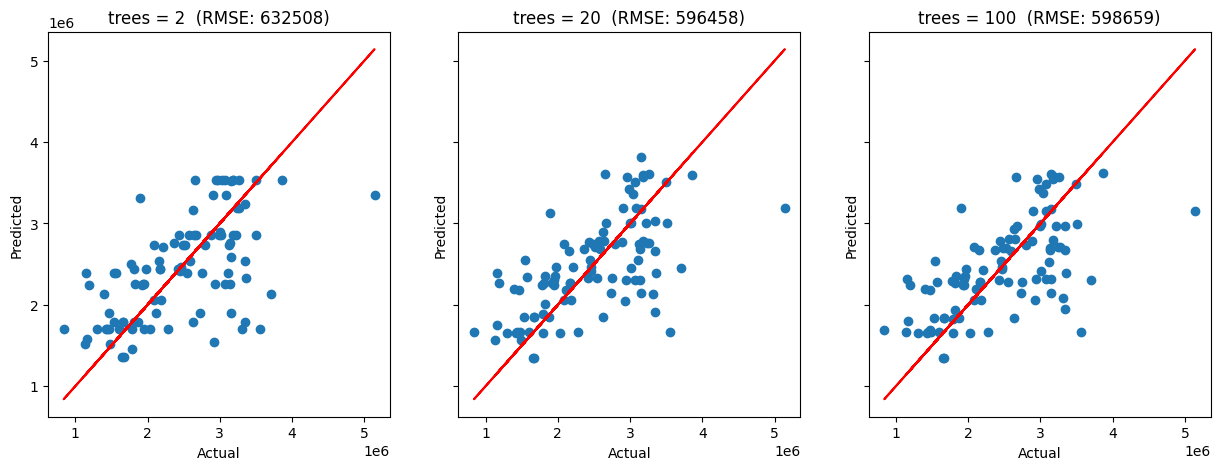

In [12]:
# Create figure and axes
f, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3,sharey=True)

# Create list of titles and predictions to use in for loop
pred = [forest_1.predict(x_test), forest_2.predict(x_test), forest_3.predict(x_test)]
title = ['trees = 2', 'trees = 20', 'trees = 100']

# Loop through all axes to plot each model's results
for i in range(3):
    rmse = round(np.sqrt(mean_squared_error(pred[i],y_test)))
    ax[i].set_title(title[i]+"  (RMSE: "+str(rmse)+ ")")
    ax[i].set_xlabel('Actual')
    ax[i].set_ylabel('Predicted')
    ax[i].plot(y_test,y_test,'r')
    ax[i].scatter(y_test,pred[i])

Looking at the RMSEs, the forest with 20 trees performed the best.

> Can you find the optimal parameters (including `max_depth` and `min_samples_leaf`)?

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=23)

param_grid = {
    'n_estimators': [20],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'absolute_error']  # Changed 'gini', 'entropy' to valid options
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # Changed scoring from 'accuracy' to 'neg_mean_squared_error' for regression
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(x_train, y_train)

print("Best Hyperparameters:")
print(grid_search.best_params_)

print("\nBest Cross-Validated Score:", -grid_search.best_score_) # Invert the score for better readability

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters:
{'criterion': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}

Best Cross-Validated Score: 272257201373.58414


## 4. Assessing variable importance

Knowing the **predictive power** – how different predictive variables affect the model's performance – can prove useful in cases where the dataset is large and high-dimensional.

It allows us to establish **which predictive variables we can discard** without significantly affecting the model's performance. Additionally, models that are presented with fewer predictor variables tend to train faster.  

Unlike decision trees, random forests can be used to calculate a **measure of predictor variable importance**.

One way to compute this measure in the regression setting is to use the training data that was left out when constructing the random forest. Then the variable importance for a given variable can be calculated by:

1. Keeping other variables the same.
2. Shuffling the value of the variable in question.
3. Calculating the percentage increase in MSE.  

This way, **more important variables** will have **higher percentage increases** in the MSE.

In sklearn's `RandomForestRegressor` we can easily obtain variable importances using:
    `model.feature_importances_`

In [16]:
from sklearn.inspection import permutation_importance

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Calculate permutation importance on the test set
result = permutation_importance(best_model, x_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# The permutation_importance function returns a dictionary-like object
# with 'importances_mean', 'importances_std', and 'importances'

# Since we only have one feature, we can directly access its importance
feature_name = 'LotArea' # Assuming the single feature is LotArea
mean_importance = result.importances_mean[0]
std_importance = result.importances_std[0]

print(f"Permutation Importance for {feature_name}:")
print(f"  Mean Importance: {mean_importance}")
print(f"  Standard Deviation: {std_importance}")

Permutation Importance for LotArea:
  Mean Importance: 513440305986.68494
  Standard Deviation: 103323552009.82645


The `permutation_importance` result shows the decrease in model performance (measured by negative mean squared error in this case) when a single feature is randomly shuffled. A larger decrease (or a more positive `mean_importance` for `neg_mean_squared_error`) indicates that the feature is more important. Since 'LotArea' is the only feature, it shows a significant importance, confirming its role in the model.

In [15]:
best_model = grid_search.best_estimator_
feature_importance = best_model.feature_importances_

print(f"Feature Importance (LotArea): {feature_importance[0]}")

Feature Importance (LotArea): 1.0


## 5. Advantages and disadvantages of random forests

**Advantages:**

* Less overfitting compared to a single decision tree (i.e. generalises much better).
* Requires little data preparation – e.g. no real need to standardise features.
* Extremely flexible and usually have high prediction accuracy.

**Disadvantages**

* Complex and not very intuitive.
* Computation costs can be high if many trees are used.